<b>Section 2: License Plate Recognition with OpenCV</b>

In [1]:
%pylab notebook

Populating the interactive namespace from numpy and matplotlib


<IPython.core.display.Javascript object>


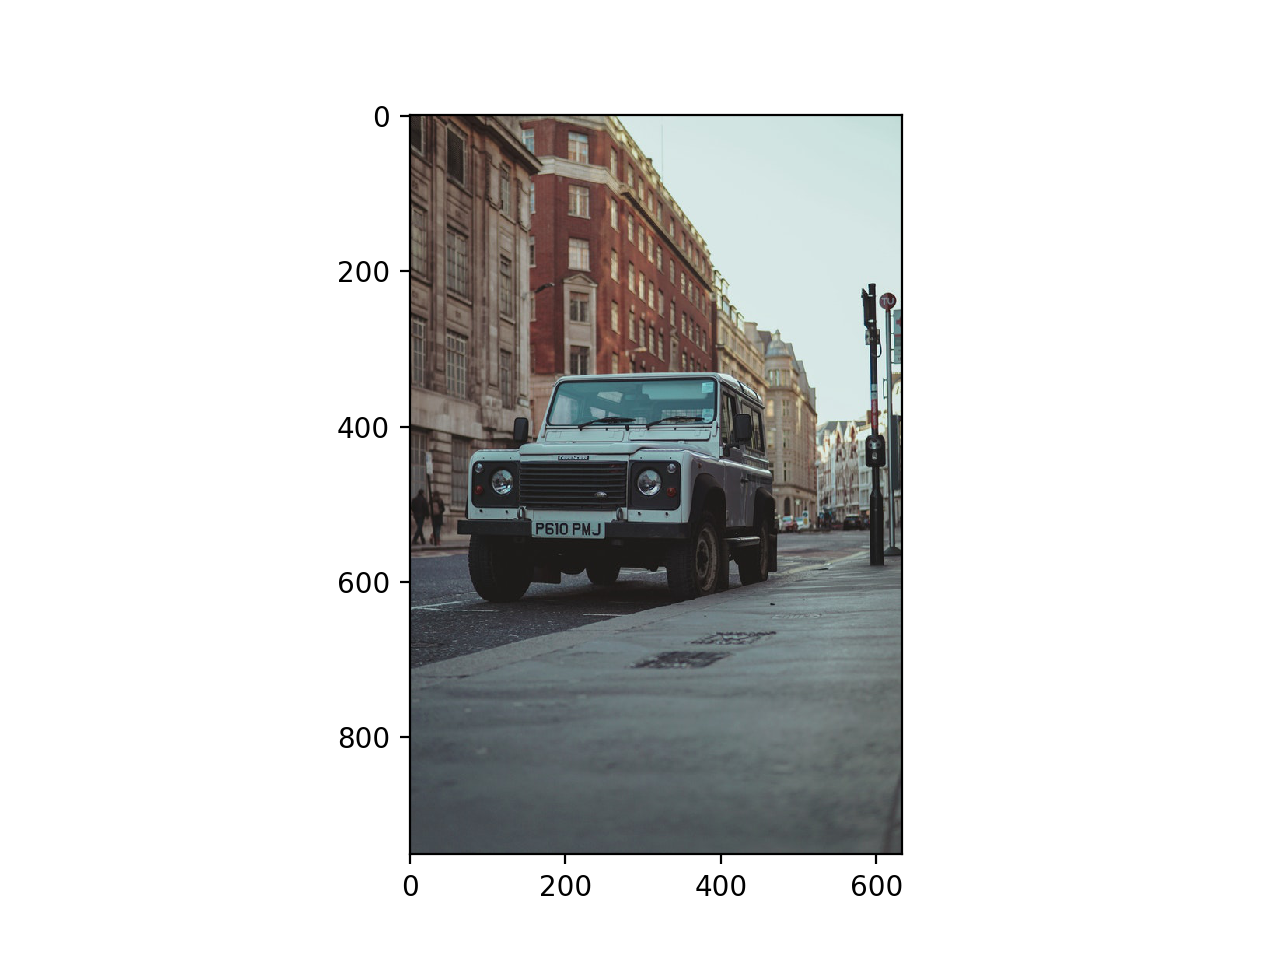

In [5]:
figure()
imshow(imread('tests/p9.jpg'))

In [6]:
# import & utility function cell
import cv2
import numpy as np
import pickle

# return gray & binarized (intensity thresholded) images for analysis
def gray_thresh_img(input_image):
    h, w, _ = input_image.shape
    grayimg = cv2.cvtColor(input_image, cv2.COLOR_BGR2HSV)[:,:,2]
    
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
    
    tophat = cv2.morphologyEx(grayimg, cv2.MORPH_TOPHAT, kernel)
    blackhat = cv2.morphologyEx(grayimg, cv2.MORPH_BLACKHAT, kernel)
    graytop = cv2.add(grayimg, tophat)
    contrastgray = cv2.subtract(graytop, blackhat)
    blurred = cv2.GaussianBlur(contrastgray, (5,5), 0)
    thesholded = cv2.adaptiveThreshold(blurred, 255.0, 
                                       cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
                                       cv2.THRESH_BINARY_INV, 19, 9)

    return grayimg, thesholded


def getmatchingchars(char_cands):
    char_list = []                  

    for char_cand in char_cands:                        
        ch_matches = []                
        for matching_candidate in char_cands:                
            if matching_candidate == char_cand:    
                continue                                
                        
            chardistance = np.sqrt((abs(char_cand.x_cent 
                                        - matching_candidate.x_cent) ** 2) 
                                   + (abs(char_cand.y_cent 
                                          - matching_candidate.y_cent)**2))
            x = float(abs(char_cand.x_cent - matching_candidate.x_cent))
            y = float(abs(char_cand.y_cent - matching_candidate.y_cent))
            angle = np.rad2deg(np.arctan(y/x) if x != 0.0 else np.pi/2)
    
            deltaarea = float(abs(matching_candidate.rect_area 
                                  - char_cand.rect_area))\
                                  / float(char_cand.rect_area)
            deltawidth = float(abs(matching_candidate.rect_w-char_cand.rect_w))\
                        / float(char_cand.rect_w)
            deltaheight = float(abs(matching_candidate.rect_h-char_cand.rect_h))\
                        / float(char_cand.rect_h)
                    
            if (chardistance < (char_cand.hypotenuse * 5.0) and
                angle < 12.0 and deltaarea < 0.5 and deltawidth < 0.8 
                and deltaheight < 0.2):
                ch_matches.append(matching_candidate)        

        ch_matches.append(char_cand)                
        if len(ch_matches) < 3:     
            continue                            
                                                
        char_list.append(ch_matches)      
                                                
        for charlist in getmatchingchars(list(set(char_cands)-set(ch_matches))):        
            char_list.append(charlist)             
        break       

    return char_list

# information container for possible characters in images
class charclass:
    def __init__(self, _contour):
        self.contour = _contour
        self.boundingRect = cv2.boundingRect(self.contour)
        self.rect_x, self.rect_y, self.rect_w, self.rect_h = self.boundingRect
        self.rect_area = self.rect_w * self.rect_h
        self.x_cent = (self.rect_x + self.rect_x + self.rect_w) / 2
        self.y_cent = (self.rect_y + self.rect_y + self.rect_h) / 2
        self.hypotenuse = np.sqrt((self.rect_w ** 2) + (self.rect_h ** 2))
        self.aspect_ratio = float(self.rect_w) / float(self.rect_h)
        
# load pre-trained scikit-learn knn digit classifier
with open('knn.p', 'rb') as f:
    knn = pickle.load(f)  

<IPython.core.display.Javascript object>


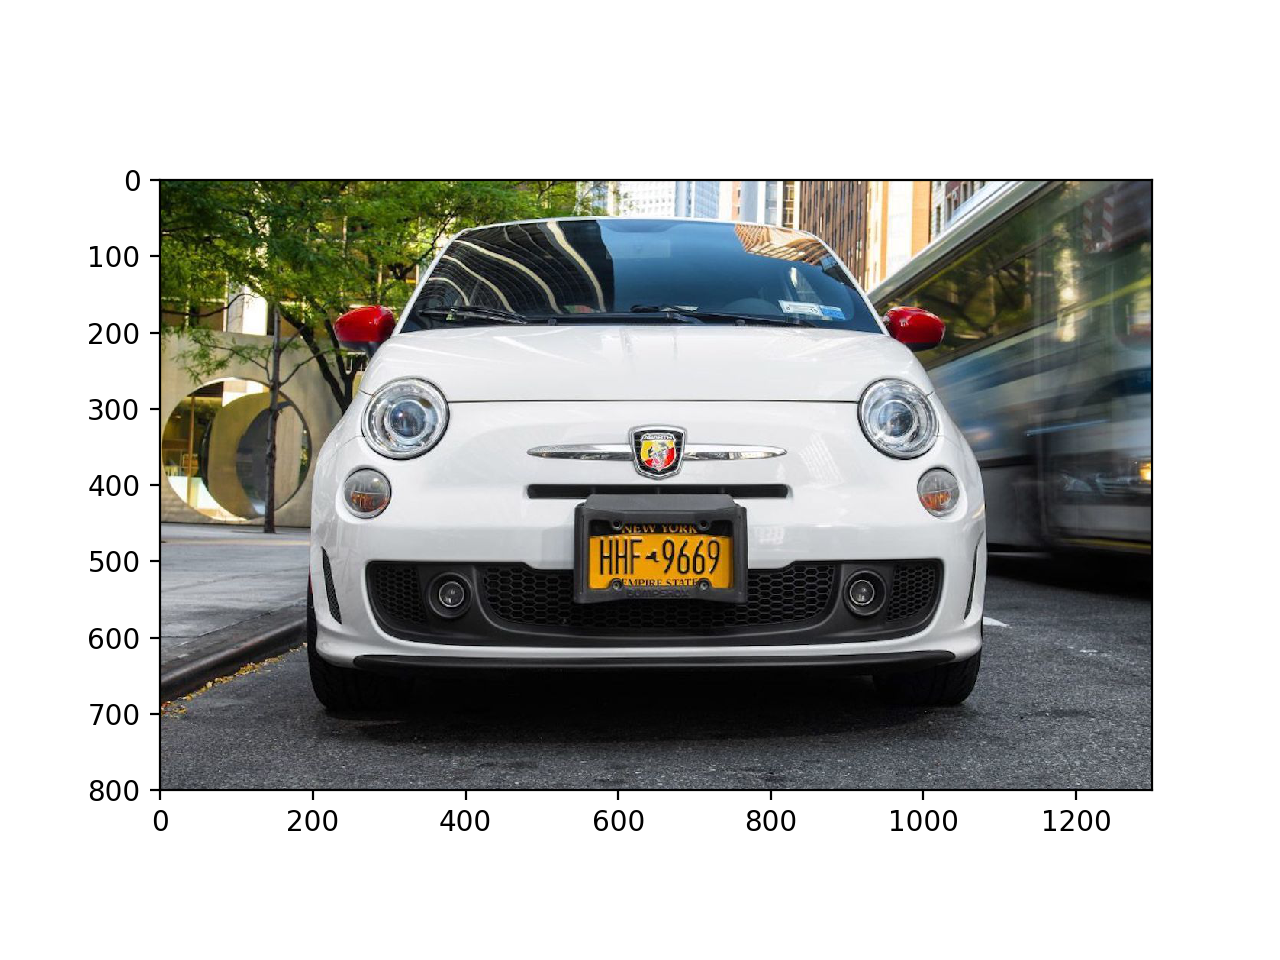

In [50]:
# Load our image, prepare to analyze
input_image  = plt.imread('tests/p1.jpg') #use cv2.imread or 
                                          #import matplotlib.pyplot as plt
                                          #if running outside notebook
figure()
imshow(input_image)

In [51]:
## begin main code
#we'll need image height, width
h, w = input_image.shape[:2] 

# We don't use color information
# + we need to binarize (theshold) image to find characters
grayimg, thesholded = gray_thresh_img(input_image)

contours = cv2.findContours(thesholded, cv2.RETR_LIST, 
                            cv2.CHAIN_APPROX_SIMPLE)[1]

# initialize variables for possible characters/plates in image
char_cands = []                
plate_candidates = [] 

In [52]:
# first pass at finding characters
for index in range(0, len(contours)):                       
    char_cand = charclass(contours[index])
    if (char_cand.rect_area > 80 and char_cand.rect_w > 2 
        and char_cand.rect_h > 8 and 0.25 < char_cand.aspect_ratio 
        and char_cand.aspect_ratio < 1.0):
         
        char_cands.append(char_cand)                        

In [53]:
#refine matches & find plate candidates
for ch_matches in getmatchingchars(char_cands):                   
    class blank: pass
    plate_candidate = blank()           

    ch_matches.sort(key = lambda ch: ch.x_cent)        
            
    plate_w = int((ch_matches[len(ch_matches) - 1].rect_x + \
                   ch_matches[len(ch_matches) - 1].rect_w - ch_matches[0].rect_x) * 1.3)

    sum_char_h = 0
    for ch in ch_matches:
        sum_char_h += ch.rect_h

    avg_char_h = sum_char_h / len(ch_matches)
    plate_h = int(avg_char_h * 1.5)
            
    y = ch_matches[len(ch_matches) - 1].y_cent - ch_matches[0].y_cent
    r = np.sqrt((abs(ch_matches[0].x_cent 
                     - ch_matches[len(ch_matches) - 1].x_cent) ** 2) 
                + (abs(ch_matches[0].y_cent 
                       - ch_matches[len(ch_matches) - 1].y_cent) ** 2))
    rotate_angle = np.rad2deg(np.arcsin(y / r))
            
    platex = (ch_matches[0].x_cent + ch_matches[len(ch_matches) - 1].x_cent) / 2
    platey = (ch_matches[0].y_cent + ch_matches[len(ch_matches) - 1].y_cent) / 2
    plate_cent = platex, platey
            
    plate_candidate.plateloc = (tuple(plate_cent), (plate_w, plate_h), 
                                rotate_angle)
            
    rotationMatrix = cv2.getRotationMatrix2D(tuple(plate_cent), rotate_angle, 1.0)

    rotated = cv2.warpAffine(input_image, rotationMatrix, 
                               tuple(np.flipud(input_image.shape[:2])))

    plate_candidate.plate_im = cv2.getRectSubPix(rotated, (plate_w, plate_h), 
                                                 tuple(plate_cent))         

    if plate_candidate.plate_im is not None:                          
        plate_candidates.append(plate_candidate)                  

In [54]:
#extract text info from plate candidates
for plate_candidate in plate_candidates:          

    plate_candidate.grayimg, plate_candidate.thesholded = \
                                gray_thresh_img(plate_candidate.plate_im)     
    plate_candidate.thesholded = cv2.resize(plate_candidate.thesholded, 
                                            (0, 0), fx = 1.6, fy = 1.6)
    thresholdValue, plate_candidate.thesholded = \
                                cv2.threshold(plate_candidate.thesholded, 
                                              0.0, 255.0, 
                                              cv2.THRESH_BINARY | cv2.THRESH_OTSU)

    contours = cv2.findContours(plate_candidate.thesholded, cv2.RETR_LIST, 
                                cv2.CHAIN_APPROX_SIMPLE)[1]

    plate_chars = []                        
    for contour in contours:                        
        char_cand = charclass(contour)
        if (char_cand.rect_area > 80 and char_cand.rect_w > 2 
            and char_cand.rect_h > 8 and 0.25 < char_cand.aspect_ratio 
            and char_cand.aspect_ratio < 1.0):
            plate_chars.append(char_cand)       

    plate_chars = getmatchingchars(plate_chars)

    if (len(plate_chars) == 0):
        plate_candidate.chars = ""
        continue

    for index in range(0, len(plate_chars)):                              
        plate_chars[index].sort(key = lambda ch: ch.x_cent)        
        filt_matching_chars = list(plate_chars[index])                

        for thischar in plate_chars[index]:
            for alt_char in plate_chars[index]:
                if thischar != alt_char:        
                    chardistance = np.sqrt((abs(thischar.x_cent-alt_char.x_cent)**2) 
                                           + (abs(thischar.y_cent-alt_char.y_cent) ** 2))
                    if chardistance < (thischar.hypotenuse * 0.3):
                        if thischar.rect_area < alt_char.rect_area:         
                            if thischar in filt_matching_chars:              
                                filt_matching_chars.remove(thischar)         
                        else:                                                                       
                            if alt_char in filt_matching_chars:                
                                filt_matching_chars.remove(alt_char)           
            
    charlistlen = 0
    char_index = 0
            
    for index in range(0, len(plate_chars)):
        if len(plate_chars[index]) > charlistlen:
            charlistlen = len(plate_chars[index])
            char_index = index
            
    full_char_list = plate_chars[char_index]
    full_char_list.sort(key = lambda ch: ch.x_cent)        

    plate_candidate.chars = ""               
    for thischar in full_char_list:                                         
        roi = plate_candidate.thesholded[thischar.rect_y : 
                                         thischar.rect_y + thischar.rect_h,
                                         thischar.rect_x : 
                                         thischar.rect_x + thischar.rect_w]

        resized_roi = np.float32(cv2.resize(roi, (20, 30)).reshape((1, -1)))
        plate_candidate.chars += str(chr(int(knn.predict(resized_roi)[0])))                        

In [55]:
# Take the best candidate to be the one with the most character matches
# and display the result.
if len(plate_candidates) > 0:                          
    plate_candidates.sort(key = lambda plate_candidate: 
                          len(plate_candidate.chars), reverse = True)
    best_plate = plate_candidates[0]
    print("License plate read: " + best_plate.chars + "\n")  

License plate read: HHF9669



<IPython.core.display.Javascript object>


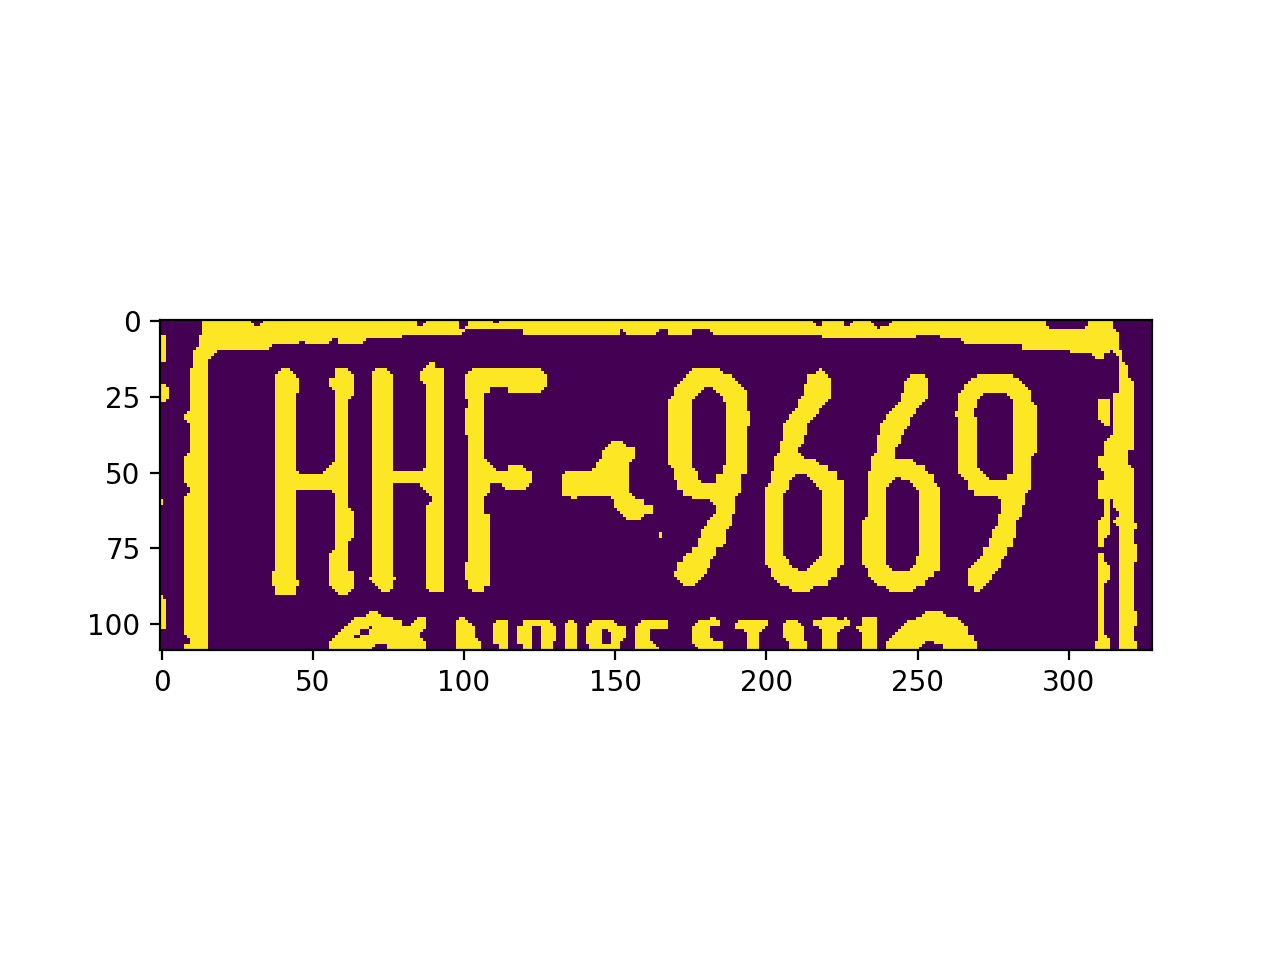

((655.0, 495.5), (205, 68), 0.0)

In [56]:
figure()
# best_plate.plate_im
imshow(best_plate.thesholded)
best_plate.plateloc